In [1]:
import nltk
nltk.download('punkt')  
print (nltk.__version__)

3.8.1


[nltk_data] Downloading package punkt to /Users/hsjack/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
import re
import sklearn
import pickle
import pandas as pd
import numpy as np
from konlpy.tag import Okt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
# 일단 dev.tsv와 train.tsv파일 불러오기
comments1 = pd.read_csv("./dev.tsv", delimiter = "\t", encoding = 'utf-8').to_numpy()
comments2 = pd.read_csv("./train.tsv", delimiter = "\t", encoding = 'utf-8').to_numpy()

comments_all = np.concatenate((comments1, comments2), axis = 0)

comments_all


array([['송중기 시대극은 믿고본다. 첫회 신선하고 좋았다.', False, 'none', 'none'],
       ['지현우 나쁜놈', False, 'none', 'offensive'],
       ['알바쓰고많이만들면되지 돈욕심없으면골목식당왜나온겨 기댕기게나하고 산에가서팔어라', False, 'none',
        'hate'],
       ...,
       ['힘내세용 ^^ 항상 응원합니닷 ^^ !', False, 'none', 'none'],
       ['힘내소...연기로 답해요.나도 53살 인데 이런일 저런일 다 있더라구요.인격을 믿습니다..홨팅', False,
        'none', 'none'],
       ['힘들면 관뒀어야지 그게 현명한거다', False, 'none', 'none']], dtype=object)

In [4]:
# 파일 불러왔으면 쓸데없는 라벨 없애기, 일단 성차별적인 발언은 다 빼버리는게 좋을 듯?
comments_all = np.array([comment for comment in comments_all if not(comment[1])])
comments_filtered = np.concatenate((comments_all[:, [0]], comments_all[:, [3]]), axis = 1)

content1 = comments_filtered[:, [0]]
label1 = np.where(comments_filtered[:, [1]] == "none", 1, 0)

data1 = np.concatenate((content1, label1), axis = 1)

print(data1)

[['송중기 시대극은 믿고본다. 첫회 신선하고 좋았다.' 1]
 ['지현우 나쁜놈' 0]
 ['알바쓰고많이만들면되지 돈욕심없으면골목식당왜나온겨 기댕기게나하고 산에가서팔어라' 0]
 ...
 ['힘내세용 ^^ 항상 응원합니닷 ^^ !' 1]
 ['힘내소...연기로 답해요.나도 53살 인데 이런일 저런일 다 있더라구요.인격을 믿습니다..홨팅' 1]
 ['힘들면 관뒀어야지 그게 현명한거다' 1]]


In [5]:
# datas = np.concatenate((data1, data2))
datas = data1
print(datas[:5])

X = datas[:, [0]].squeeze()
y = datas[:, [1]].squeeze().astype("int")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, stratify = y)

print(X_train.shape)

[['송중기 시대극은 믿고본다. 첫회 신선하고 좋았다.' 1]
 ['지현우 나쁜놈' 0]
 ['알바쓰고많이만들면되지 돈욕심없으면골목식당왜나온겨 기댕기게나하고 산에가서팔어라' 0]
 ['이미자씨 송혜교씨 돈이 그리 많으면 탈세말고 그돈으로 평소에 불우이웃에게 기부도 좀 하고사시죠.' 0]
 ['일베충들 ㅂㄷ거리는것봐라 ㅉㅉ' 0]]
(6361,)


In [6]:
# 문장의 전처리를 위함
def preprocessor(text):
    text = re.sub("\W+", ' ', text)     # remove all non-words
    text = re.sub("^\s", '', text)      # remove space in start of the statement
    text = re.sub("\s$", '', text)      # remove space in end of the statement
    return text
    

# 텍스트를 처리하기 위해 Okt 사용
okt = Okt()
def tokenizer_kor(text) :
    return okt.morphs(text, stem = True, norm = True)

In [7]:
# 전처리 테스트
print(X[22])
preprocessor(X[22])

한화이글스 해산하자!!! 丕빱♡


'한화이글스 해산하자 丕빱'

In [23]:
# TF-IDF로 벡터화하기
tfidf = TfidfVectorizer(preprocessor = preprocessor,
                        tokenizer = tokenizer_kor,
                        max_df = 0.2,
                        min_df = 3)

X_train_vector = tfidf.fit_transform(X_train)
X_test_vector = tfidf.transform(X_test)

# 파일로 tfidf전처리 저장
with open("./tfidf_new.pkl", "wb") as f :
    pickle.dump(tfidf, f)

In [24]:
X_train_vector = X_train_vector.toarray()
X_test_vector = X_test_vector.toarray()

In [25]:
print(X_train_vector[0].shape)

(3651,)


In [26]:
# 실제로 모델에 넣고 정확도 측정해보기
lr = LogisticRegression(C = 0.6, penalty = 'l2', max_iter = 100)
lr.fit(X_train_vector, y_train)

with open("./linear_model_new.pkl", "wb") as f :
    pickle.dump(lr, f)

In [27]:
print(f"Training Accuracy     : {lr.score(X_train_vector, y_train) * 100:.2f}%")
print(f"Test Accuracy \t      : {lr.score(X_test_vector, y_test) * 100:.2f}%")

Training Accuracy     : 81.87%
Test Accuracy 	      : 71.99%


(7, 5)
(7,)


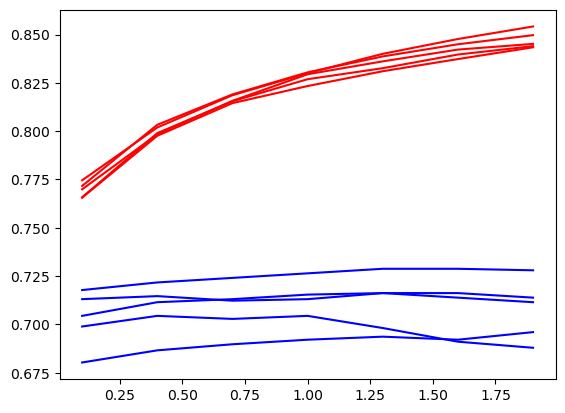

In [14]:
from sklearn.model_selection import validation_curve
from matplotlib import pyplot as plt

param_range = np.arange(0.1, 2.05, 0.3)

train_scores, test_scores = validation_curve(lr,
                                             X = X_train_vector,
                                             y = y_train,
                                             param_name = "C",
                                             param_range = param_range)

print(train_scores.shape)
print(param_range.shape)

plt.plot(param_range, train_scores, color = 'r', label = "Training Accuracy")
plt.plot(param_range, test_scores, color = 'b', label = "testing Accuracy")
plt.show()

In [107]:
def 착한댓글판별기(text) :
    test = np.array(text).reshape(1, )
    result = lr.predict(tfidf.transform(test).toarray()).item()
    return True if result == 1 else False

result = 착한댓글판별기("게임 잘하는 배민 존나 고마운분 아기 다람쥐 최인석")
if result :
    print("부정적이지 않은 댓글입니다")
else :
    print("부정적 댓글입니다")

부정적이지 않은 댓글입니다


In [ ]:
# 같은 방법으로 unsmile친구들 데려오기
# 근데 얘들은 빼버려도 될 듯??? 주제에 벗어난 발언이 많음
comments1 = pd.read_csv("unsmile_train_v1.0.tsv", delimiter = "\t", encoding = 'utf-8').to_numpy()
comments2 = pd.read_csv("unsmile_valid_v1.0.tsv", delimiter = "\t", encoding = 'utf-8').to_numpy()

comments_all = np.concatenate((comments1, comments2), axis = 0)
comments_all

array([['일안하는 시간은 쉬고싶어서 그런게 아닐까', 0, 0, ..., 0, 1, 0],
       ['아동성범죄와 페도버는 기록바 끊어져 영원히 고통 받는다. 무슬림 50퍼 근친이다. 10 16까지 IQ 떨어지고 출산 위험은 400% 다.',
        0, 0, ..., 0, 0, 0],
       ['루나 솔로앨범 나왔을 때부터 머모 기운 있었음 ㅇㅇ Keep o  doin 진짜 띵곡임 꼭 들어보셈"', 0, 0,
        ..., 0, 1, 0],
       ...,
       ['막노동을 해도 한국에살고말지 미쳤다고 남미를가냐?차라리 자살을하겠다.', 0, 0, ..., 0, 0, 0],
       ['‘사형을 구형하였으나 여성인 점을 감안해 25년 선고’ ???내가 뭐 잘못본건가?개시발 보지민국 보빨새끼들', 1,
        0, ..., 0, 0, 0],
       ['참군남이노 남자의 용도는 고기방패다 ㅋㅋㅋ', 0, 1, ..., 0, 0, 0]], dtype=object)

In [ ]:
# 여기도 clean과 clean이외의 댓글로 나누기
content2 = comments_all[:, [0]]
label2 = comments_all[:, [10]]

data2 = np.concatenate((content2, label2), axis = 1)

print(data2)

[['일안하는 시간은 쉬고싶어서 그런게 아닐까' 1]
 ['아동성범죄와 페도버는 기록바 끊어져 영원히 고통 받는다. 무슬림 50퍼 근친이다. 10 16까지 IQ 떨어지고 출산 위험은 400% 다.'
  0]
 ['루나 솔로앨범 나왔을 때부터 머모 기운 있었음 ㅇㅇ Keep o  doin 진짜 띵곡임 꼭 들어보셈"' 1]
 ...
 ['막노동을 해도 한국에살고말지 미쳤다고 남미를가냐?차라리 자살을하겠다.' 0]
 ['‘사형을 구형하였으나 여성인 점을 감안해 25년 선고’ ???내가 뭐 잘못본건가?개시발 보지민국 보빨새끼들' 0]
 ['참군남이노 남자의 용도는 고기방패다 ㅋㅋㅋ' 0]]
